### Basic Cicuit Model:

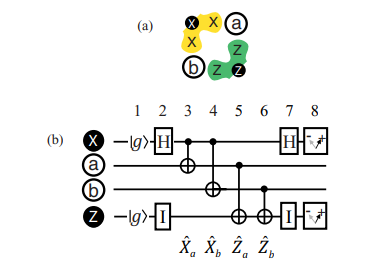

With 3D noise 

In [1]:
from qutip import *
from qutip import gates
from qutip import qeye, sigmax, basis, tensor, expect
from qutip import Qobj
from qutip import ket2dm, basis, ptrace, tensor

import numpy as np
from collections import defaultdict
from numpy.random import multivariate_normal, choice
import scipy.sparse as sp

import matplotlib.pyplot as plt
from itertools import product
from itertools import product
from functools import partial, reduce
from operator import mul
from itertools import product

from qutip import Qobj, qeye, sigmax, basis, tensor
from qutip.measurement import measure

from collections import Counter

# my noise file
import depolarizing_noise
from depolarizing_noise import *
from depolarizing_noise import ibm_sherbrooke_params


In [2]:
def print_state_nicely(state):
    state = state.full().flatten()  # Convert to a flat NumPy array
    n_qubits = int(np.log2(len(state)))
    basis_labels = [''.join(map(str, bits)) for bits in product([0, 1], repeat=n_qubits)]

    for amplitude, label in zip(state, basis_labels):
        if np.abs(amplitude) > 1e-10:  # Only show significant components
            print(f"{amplitude:.3g} |{label}>")

In [3]:
def single_qubit_gate(G, target, N=4):
    ops = [qeye(2)] * N
    ops[target] = G
    return Qobj(tensor(ops).full())

In [4]:
def manual_cnot(control, target, N=4, flatten=True):
    """
    Constructs a CNOT gate on an N-qubit system where `control` and `target` are the qubit indices.
    If `flatten=True`, returns the result as a 2^N x 2^N operator with dims=[[2^N], [2^N]].
    """
    if control == target:
        raise ValueError("Control and target must be different.")
    if not (0 <= control < N) or not (0 <= target < N):
        raise ValueError(f"Qubit indices must be between 0 and {N-1}")

    I = qeye(2)
    X = sigmax()
    P0 = basis(2, 0) * basis(2, 0).dag()
    P1 = basis(2, 1) * basis(2, 1).dag()

    def build_term(ctrl_proj, target_op):
        ops = []
        for i in range(N):
            if i == control:
                ops.append(ctrl_proj)
            elif i == target:
                ops.append(target_op)
            else:
                ops.append(I)
        return tensor(ops)

    U = build_term(P0, I) + build_term(P1, X)

    if flatten:
        return Qobj(U.full(), dims=[[2**N], [2**N]])
    else:
        return U  # return with proper qubit-structured dims



In [5]:

def custom_measure(psi_original, i, N):
    """
    Manually perform a projective measurement on qubit `i` of an N-qubit pure state,
    returning the measurement result and collapsed (pure) state.
    """
    if i < 0 or i >= N:
        raise ValueError(f"Invalid qubit index i={i} for N={N}")

    # Ensure correct structure of the state
    psi = psi_original.copy()
    dim_list = [[2]*N, [1]*N]
    psi = Qobj(psi.full().reshape((2**N, 1)), dims=dim_list)

    # Build projectors P0 and P1 for qubit i
    P0_list = [qeye(2)] * N
    P1_list = [qeye(2)] * N
    P0_list[i] = basis(2, 0) * basis(2, 0).dag()
    P1_list[i] = basis(2, 1) * basis(2, 1).dag()
    P0 = tensor(P0_list)
    P1 = tensor(P1_list)
    
    # Compute probabilities (unnormalized)
    p0 = float((psi.dag() * P0 * psi).real)
    p1 = float((psi.dag() * P1 * psi).real)

    total = p0 + p1
    p0_norm = p0 / total if total > 0 else 0
    p1_norm = p1 / total if total > 0 else 0

    # Sample measurement outcome
    outcome = np.random.choice([0, 1], p=[p0_norm, p1_norm])

    # Collapse the state based on outcome
    if outcome == 0:
        collapsed = (P0 * psi).unit()
    else:
        collapsed = (P1 * psi).unit()

    return outcome, collapsed


In [6]:


def noisy_reset_with_gate(psi_og, i, N, p, T1, T2, tg, additional_noise = False):
    """
    Reset a qubit to |0⟩ via:
    - projective measurement
    - conditional application of a noisy X gate if outcome == 1
    """
    theta=np.pi
    phi=0
    psi=np.pi/2
    
    outcome, collapsed_state = custom_measure(psi_og, i, N)  # Measure qubit 0 and get collapsed state

    if outcome == 0:
        return collapsed_state
    else:
        # Apply noisy X gate (you already have it defined with correct params)
        noisy_X = Qobj(X_gate_construction(p, T1, T2, tg, additional_noise))
        U = single_qubit_gate(noisy_X, i, N)
        collapsed_state_full = Qobj(collapsed_state.full())  # Fix dims
        new_state = U * collapsed_state_full
        return new_state


In [7]:
# Example: 4-qubit entangled state (e.g., Bell pair on first two)
psi = tensor(basis(2,0), basis(2,1), basis(2,0), basis(2,0))  # |0100⟩
print_state_nicely(psi)

# Fix: use N=4 (not N=2) since psi is a 4-qubit state
result, collapsed_state = custom_measure(psi, i=1, N=4)

# Apply X gate to qubit 1 (if needed, e.g., after measurement outcome == 1)
U = single_qubit_gate(gates.sigmax(), 1, 4)

# Fix: apply to collapsed state, not original
psi1 = U * Qobj(collapsed_state.full())

print_state_nicely(psi1)


1+0j |0100>
1+0j |0000>


In [8]:
i = 1 # apply reset on qubit 1
N = 4 # number of qubits

# calll ibm params
p, T1, T2, tg = depolarizing_noise.ibm_sherbrooke_params()
p_sim=p*1000

psi = tensor(basis(2,0) , basis(2,1), basis(2,1), basis(2,0))  # |0000⟩
print("Psi before reset on qubit", i, ": ")
print_state_nicely(psi)
print("Psi after reset on qubit", i, ": ")

print_state_nicely(noisy_reset_with_gate(psi,i,N, p_sim, T1, T2, tg))

Psi before reset on qubit 1 : 
1+0j |0110>
Psi after reset on qubit 1 : 
0.981-0.0283j |0010>
-0.0186-0.189j |0110>


In [9]:
def measure_all(psi_original, N):
    """
    Sequentially measure all qubits in a pure N-qubit state using custom_measure.
    Returns the measurement result as a bitstring and the final collapsed state.
    """
    psi = psi_original.copy()
    result_bits = []

    for i in range(N):
        outcome, psi = custom_measure(psi, i, N)
        result_bits.append(str(outcome))

    bitstring = ''.join(result_bits)
    return bitstring, psi


In [10]:
def simulate_circuit(psi, shots=1000):
    """
    Simulate projective measurement of all qubits using measure_all
    for a specified number of shots. Works on 4-qubit pure states.
    """
    N = 4
    outcomes = []

    for _ in range(shots):
        bitstring, psi_out = measure_all(psi, N)
        outcomes.append(bitstring)

    # Count frequencies of all 16 possible bitstrings
    labels = [''.join(bits) for bits in product('01', repeat=N)]
    counts = {label: outcomes.count(label) for label in labels}

    # Plot
    plt.bar(counts.keys(), counts.values(), color='skyblue')
    plt.title(f"Measurement outcomes over {shots} shots")
    plt.xlabel("Basis state")
    plt.ylabel("Counts")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [11]:
psi = tensor(basis(2, 1), basis(2, 0), basis(2, 1), basis(2, 0))  # |1010⟩
bitstring, final_state = measure_all(psi, N=4)

print(f"Measurement result: {bitstring}")
print_state_nicely(final_state)


Measurement result: 1010
1+0j |1010>


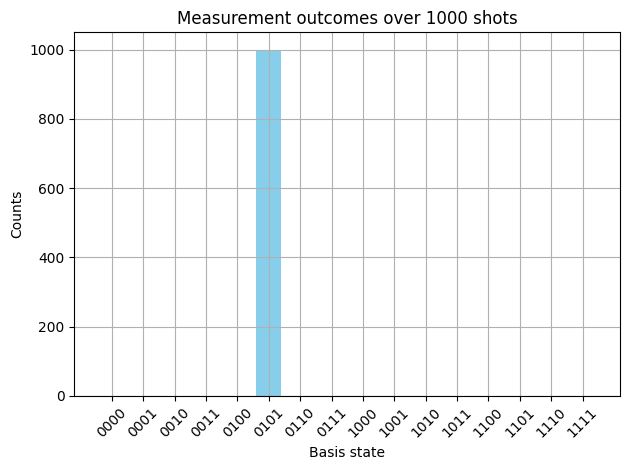

In [12]:
psi = tensor(basis(2, 0), basis(2, 1), basis(2, 0), basis(2, 1))  # |0101⟩
simulate_circuit(psi, shots=1000)


### Initialize State

### Input State Definition

The input state is prepared as:

$$
|\psi_{\text{in}}\rangle = |0\rangle \otimes |\Phi^+\rangle \otimes |0\rangle
$$

where the Bell state is:

$$
|\Phi^+\rangle = \frac{1}{\sqrt{2}} \left( |00\rangle + |11\rangle \right)
$$

Expanding the full 4-qubit tensor product gives:

$$
|\psi_{\text{in}}\rangle = \frac{1}{\sqrt{2}} \left( |0000\rangle + |0110\rangle \right)
$$

In [13]:
# Define custom entangled state
A, B, C, D = 1, 0, 0, 1
state_vector = np.array([A, B, C, D])
norm = np.linalg.norm(state_vector)
state_vector = state_vector / norm

# Create q1-q2 2-qubit entangled state
data_state = Qobj(state_vector, dims=[[2, 2], [1, 1]])

# q0 and q3 in |0>
zero = basis(2, 0)
psi0 = tensor(zero, data_state, zero)  # q0 ⊗ (q1,q2) ⊗ q3
psi0_flat = Qobj(psi0.full())  # Flatten to 4x1

print_state_nicely(psi0)


0.707+0j |0000>
0.707+0j |0110>


Noisy H Gate

In [14]:
noisy_H_gate = H_gate_construction(p_sim, T1, T2, tg)
noisy_H_gate

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.72359423+0.29441812j  0.79107104+0.20539776j]
 [ 0.79107104-0.20539776j -0.72359423+0.29441812j]]

### One Cycle of 2x2 Surface Code

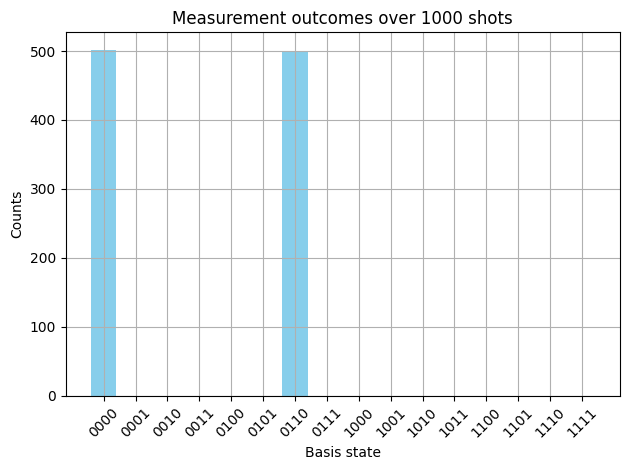

Measurement on qubit 0: 0
Measurement on qubit 3: 0


In [15]:
# Step 1: Build the full unitary
U = single_qubit_gate(noisy_H_gate, 0, 4)              # Apply H to qubit 0
U *= manual_cnot(0, 1, 4)                   # CNOT q0 → q1
U *= manual_cnot(0, 2, 4)                   # CNOT q0 → q2
U *= manual_cnot(1, 3, 4)                   # CNOT q1 → q3
U *= manual_cnot(2, 3, 4)                   # CNOT q2 → q3
U *= single_qubit_gate(noisy_H_gate, 0, 4)            # Apply another H to qubit 0

# Step 2: Apply U to initial state
psi1 = U * psi0_flat                       # psi0_flat must be a 4-qubit pure state

# Step 3: Measure qubit 0 → get collapsed state
result0, psi1_after_q0 = custom_measure(psi1, i=0, N=4)

# Step 4: Measure qubit 3 → on the post-q0-collapsed state
result3, psi1_after_q3 = custom_measure(psi1_after_q0, i=3, N=4)

# Step 5: Plot result and print outcomes
simulate_circuit(psi1_after_q3, shots=1000)

print("Measurement on qubit 0:", result0)
print("Measurement on qubit 3:", result3)


In [16]:
def simulate_noisy_4_qubit_surface(psi0_flat, p, T1, T2, tg, shots=100, plot_bool=False, additional_noise=False):
    """
    Simulate a 4-qubit noisy circuit with fresh noise per shot.
    - psi0_flat: initial 4-qubit state
    - H_gate_construction: function to generate noisy H gates
    - manual_cnot: function to construct full-system CNOT gate
    - p, T1, T2, tg: noise parameters
    - shots: number of circuit repetitions
    """
    outcomes = []
    psi_outcomes = []

    for _ in range(shots):
        # Step 0: reset qubits 0, 3 at the start 
        psi_in = noisy_reset_with_gate(psi0_flat,0,4, p, T1, T2, tg, additional_noise)
        psi_in = noisy_reset_with_gate(psi_in,3,4, p, T1, T2, tg, additional_noise)
        
        # Step 1: Rebuild circuit with fresh noisy H gates
        U = single_qubit_gate(Qobj(H_gate_construction(p, T1, T2, tg, additional_noise)), 0, 4)
        U *= manual_cnot(0, 1, 4)
        U *= manual_cnot(0, 2, 4)
        U *= manual_cnot(1, 3, 4)
        U *= manual_cnot(2, 3, 4)
        U *= single_qubit_gate(Qobj(H_gate_construction(p, T1, T2, tg, additional_noise)), 0, 4)
        
        # Step 2: Apply noisy circuit to fresh initial state
        U = Qobj(U.full(), dims=[[2]*4, [2]*4])
        psi = U * psi_in

        
        psi_outcomes.append(psi)
        
        # Step 3: Measure qubits 0 and 3 sequentially
        result0, psi = custom_measure(psi, i=0, N=4)
        result3, psi = custom_measure(psi, i=3, N=4)

        # Step 4: Measure remaining qubits (1 and 2) to get full bitstring
        result1, psi = custom_measure(psi, i=1, N=4)
        result2, psi = custom_measure(psi, i=2, N=4)

        # Step 5: Assemble outcome bitstring in correct qubit order (0 to 3)
        bitstring = f"{result0}{result1}{result2}{result3}"
        outcomes.append(bitstring)

    # Tally and plot
    counts = Counter(outcomes)
    labels = [''.join(bits) for bits in product('01', repeat=4)]
    counts = {label: counts.get(label, 0) for label in labels}

    # Plot
    if plot_bool:
        plt.bar(counts.keys(), counts.values(), color='skyblue')
        plt.title(f"Noisy 4-qubit Surface Code outcomes over {shots} shots"+ 
            f'\n $p = {p:.3e}$',)
        plt.xlabel("Basis state", fontsize=13)
        plt.ylabel("Counts", fontsize=13)
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return counts, psi_outcomes



In [62]:
shots = 1000  # Number of shots for the simulation
counts, psi_outcomes = simulate_noisy_4_qubit_surface(
    psi0_flat,
    p_sim, T1, T2, tg,
    shots=shots,
    plot_bool=False,
    additional_noise=True
)



C:\Users\npace\AppData\Local\Temp\ipykernel_66556\1251782374.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


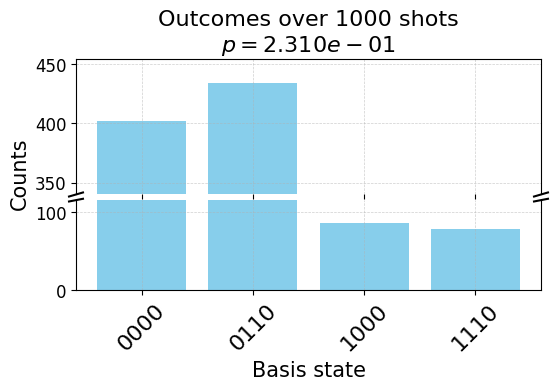

In [64]:
counts = {k: v for k, v in counts.items() if v > 0}

keys = list(counts.keys())
values = np.array(list(counts.values()))

fig, (ax_upper, ax_lower) = plt.subplots(
    2, 1, sharex=True, figsize=(6, 3),
    gridspec_kw={'height_ratios': [3, 2], 'hspace': 0.05}
)

# Bar plots on both axes (same data)
ax_upper.bar(keys, values, color='skyblue')
ax_lower.bar(keys, values, color='skyblue')

# Set y-limits to break the axis visually
break_start = 115
break_end = 340
ax_lower.set_ylim(0, break_start)  # low counts
ax_upper.set_ylim(break_end, values.max() + 20)  # high counts

# Hide spines between the plots
ax_upper.spines['bottom'].set_visible(False)
ax_lower.spines['top'].set_visible(False)
ax_upper.tick_params(labeltop=False)
ax_lower.xaxis.tick_bottom()

# Diagonal break marks
d = .015
kwargs = dict(transform=ax_upper.transAxes, color='k', clip_on=False)
ax_upper.plot((-d, +d), (-d, +d), **kwargs)
ax_upper.plot((1 - d, 1 + d), (-d, +d), **kwargs)

kwargs.update(transform=ax_lower.transAxes)
ax_lower.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax_lower.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# Add labels and title
#ax_upper.set_ylabel("Counts")
#ax_lower.set_ylabel("Counts")
ax_lower.set_xlabel("Basis state", fontsize=15)
ax_upper.set_title(f"Outcomes over {shots} shots\n$p = {p_sim:.3e}$", fontsize=16)

plt.xticks(rotation=45, fontsize = 16)
ax_upper.tick_params(axis='y', labelsize=12)
ax_lower.tick_params(axis='y', labelsize=12)
ax_upper.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
ax_lower.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
fig.text(0.015, 0.5, 'Counts', va='center', rotation='vertical', fontsize=15)
plt.show()


In [66]:
counts

{'0000': 402, '0110': 434, '1000': 86, '1110': 78}

# Compute evaluation metrics

### Running Trace Estimate

We estimate the trace of the (possibly unnormalized) state $\rho_i = |\psi_i\rangle \langle\psi_i|$ at each shot $i$ via $\mathrm{Tr}(\rho_i) = \langle \psi_i | \psi_i \rangle = \|\psi_i\|^2$.  
The running average $\frac{1}{n} \sum_{i=1}^n \|\psi_i\|^2$ and standard deviation track the convergence and deviation across repeated trials.


In [54]:
trace_vals = [psi.norm()**2 for psi in psi_outcomes]


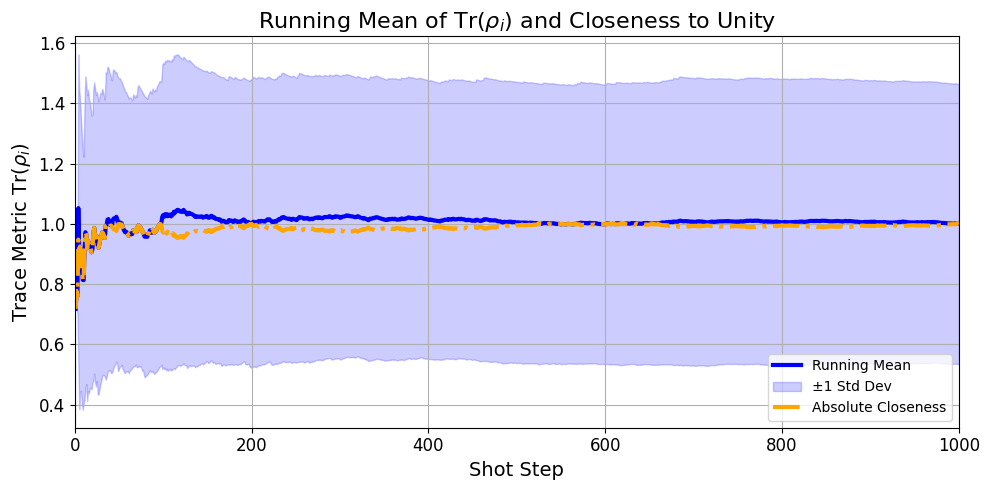

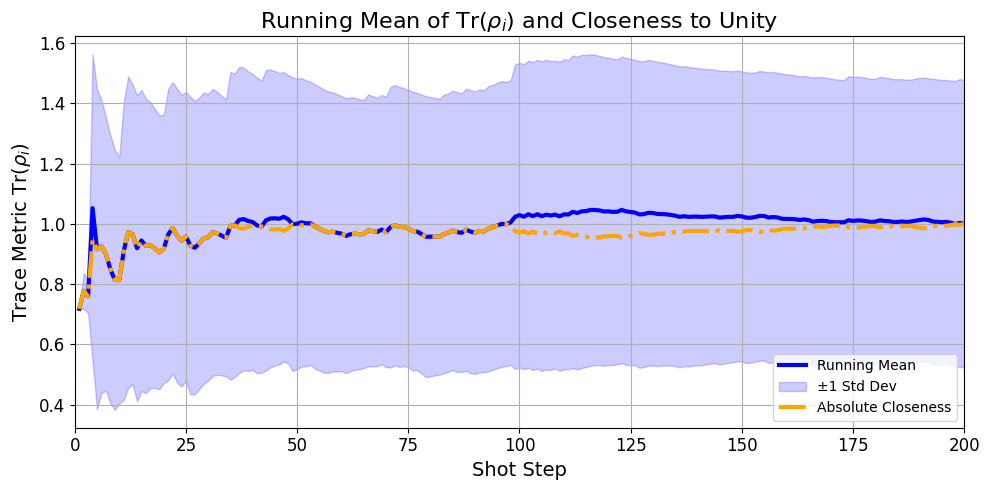

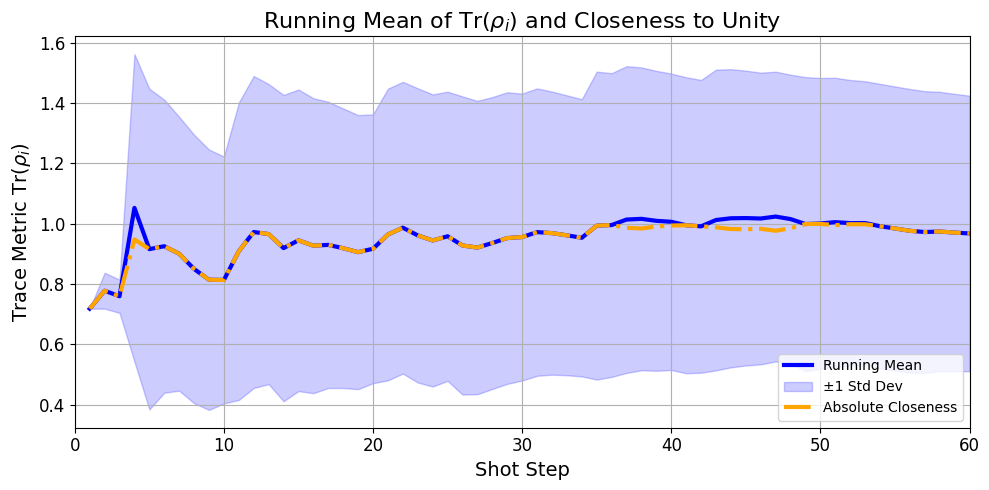

In [20]:
def plot_trace_metrics(trace_vals, max_steps=None):
    """
    Plot the running mean of trace values and their absolute closeness to unity.
    
    Parameters:
    - trace_vals: list or array of trace estimates (e.g., [psi.norm()**2 for psi in psi_outcomes])
    - max_steps: int, number of steps to include in the plot (default = all)
    """
    # Trim to max_steps if provided
    if max_steps is not None:
        trace_vals = trace_vals[:max_steps]
    
    # Initialize containers
    running_mean = []
    running_std = []

    for i in range(1, len(trace_vals) + 1):
        current_vals = trace_vals[:i]
        mean = np.mean(current_vals)
        std = np.std(current_vals)
        running_mean.append(mean)
        running_std.append(std)

    # Convert to arrays
    running_mean = np.array(running_mean)
    running_std = np.array(running_std)
    steps = np.arange(1, len(trace_vals) + 1)

    # Compute closeness to unity: 1 - |1 - mean|
    closeness_to_one = 1 - np.abs(1 - running_mean)

    # --- Plot ---
    plt.figure(figsize=(10, 5))

    # Running mean
    plt.plot(steps, running_mean, label='Running Mean', color='blue', linewidth=3)

    # Std dev band
    plt.fill_between(steps,
                     running_mean - running_std,
                     running_mean + running_std,
                     color='blue',
                     alpha=0.2,
                     label='±1 Std Dev')

    # Closeness to unity
    plt.plot(steps, closeness_to_one, label='Absolute Closeness', color='orange', linestyle='-.', linewidth=3)

    # Formatting
    plt.xlabel('Shot Step', fontsize=14)
    plt.ylabel(r'Trace Metric $\mathrm{Tr}(\rho_i)$', fontsize=14)
    plt.title(r'Running Mean of $\mathrm{Tr}(\rho_i)$ and Closeness to Unity', fontsize=16)
    plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(0,max_steps)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_trace_metrics(trace_vals, max_steps=shots)  # Plot first 500 steps
plot_trace_metrics(trace_vals, max_steps=200)  # Plot first 500 steps
plot_trace_metrics(trace_vals, max_steps=60)  # Plot first 500 steps


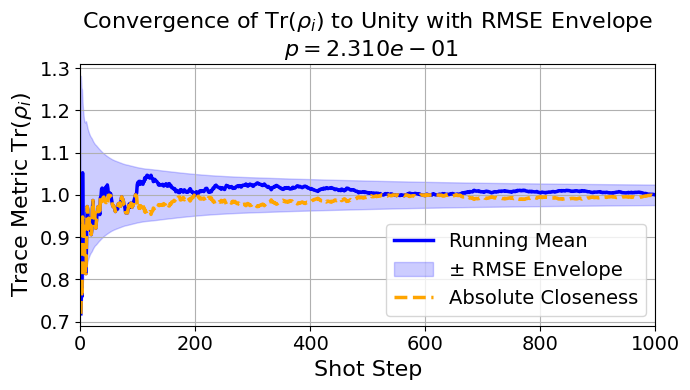

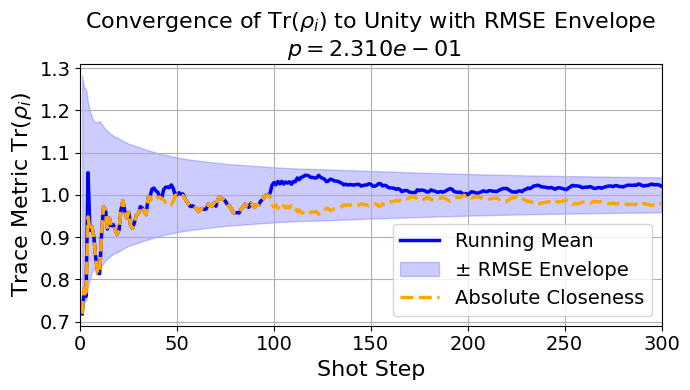

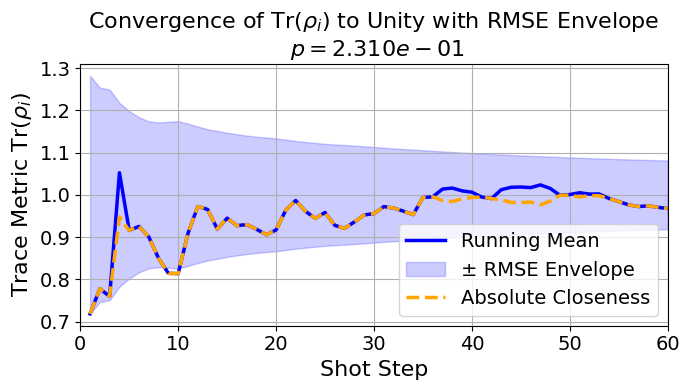

In [21]:
def plot_trace_metrics_convergence(trace_vals,p, max_steps=None):
    """
    Plot running mean of trace values with convergence indicators showing how the values approach 1.
    
    Parameters:
    - trace_vals: list or array of trace estimates
    - max_steps: int, number of steps to include in the plot
    """
    trace_vals = np.array(trace_vals)
    if max_steps is not None:
        trace_vals = trace_vals[:max_steps]

    steps = np.arange(1, len(trace_vals) + 1)
    running_mean = np.cumsum(trace_vals) / steps
    closeness_to_one = 1 - np.abs(1 - running_mean)

    # Compute squared error to 1 and RMSE-style envelope
    squared_errors = (running_mean - 1.0) ** 2
    rmse_envelope = np.sqrt(np.cumsum(squared_errors) / steps)

    # --- Plot ---
    plt.figure(figsize=(7, 4))

    # Plot running mean
    plt.plot(steps, running_mean, label='Running Mean', color='blue', linewidth=2.5)

    # Envelope around 1 ± RMSE
    plt.fill_between(steps,
                     1 - rmse_envelope,
                     1 + rmse_envelope,
                     color='blue',
                     alpha=0.2,
                     label='± RMSE Envelope')

    # Plot closeness to 1
    plt.plot(steps, closeness_to_one, label='Absolute Closeness', color='orange', linestyle='--', linewidth=2.5)

    # Formatting
    plt.xlabel('Shot Step', fontsize=16)
    plt.ylabel(r'Trace Metric $\mathrm{Tr}(\rho_i)$', fontsize=16)
    plt.title(
        fr'Convergence of $\mathrm{{Tr}}(\rho_i)$ to Unity with RMSE Envelope' + 
        f'\n $p = {p:.3e}$',
        fontsize=16)
    plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0), fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0, max_steps)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Demo with synthetic values
plot_trace_metrics_convergence(trace_vals, p_sim, max_steps=shots)
plot_trace_metrics_convergence(trace_vals, p_sim, max_steps=300)
plot_trace_metrics_convergence(trace_vals, p_sim, max_steps=60)


Compute Fidelity Running Total

### Running Fidelity Estimate

We estimate the fidelity between each outcome $\rho_i$ and the ideal target state $\rho_{\mathrm{ideal}}$ using:
$$
\mathcal{F}(\rho_i, \rho_{\mathrm{ideal}}) = \left( \mathrm{Tr} \sqrt{ \sqrt{\rho_{\mathrm{ideal}}} \rho_i \sqrt{\rho_{\mathrm{ideal}}} } \right)^2
$$

The plot shows the running mean fidelity $\langle \mathcal{F} \rangle$ over repeated shots, along with its standard deviation and closeness to unity.


In [22]:
ideal_state = psi0_flat

In [23]:
fidelity_vals = [fidelity(psi, ideal_state) for psi in psi_outcomes]


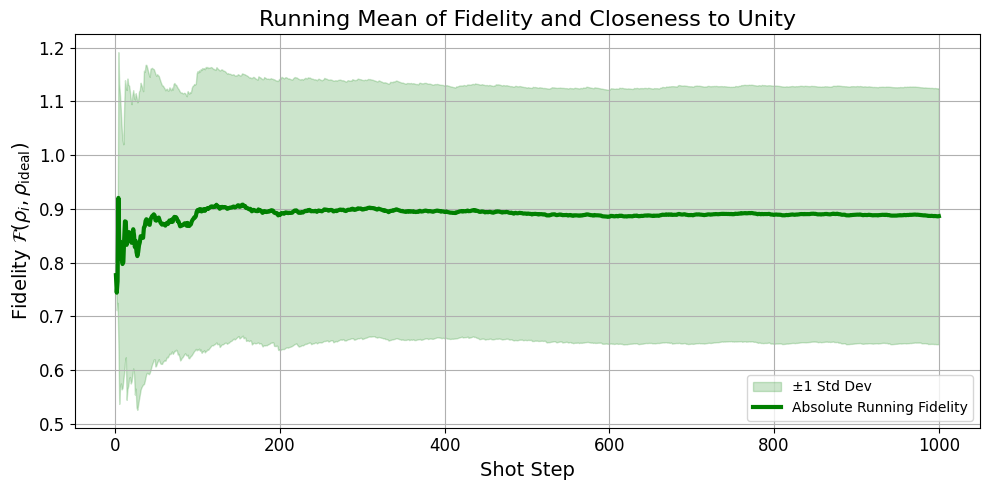

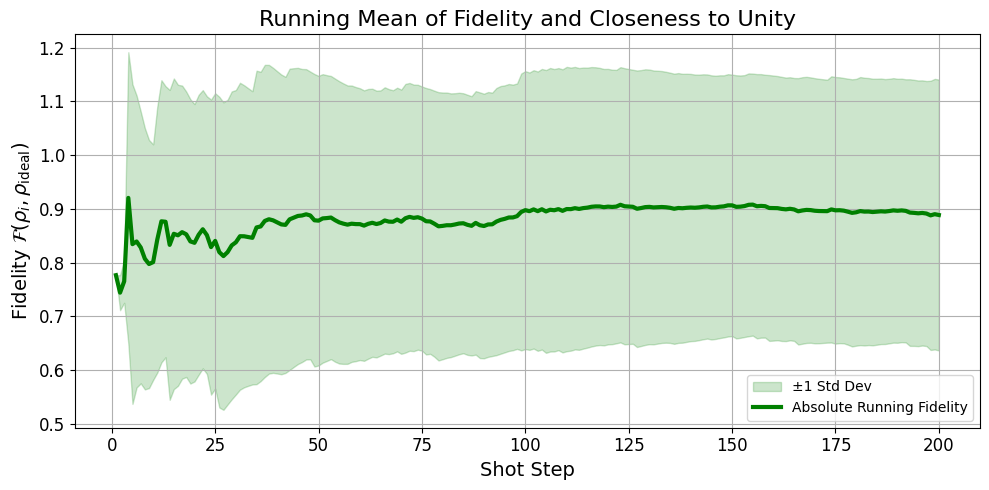

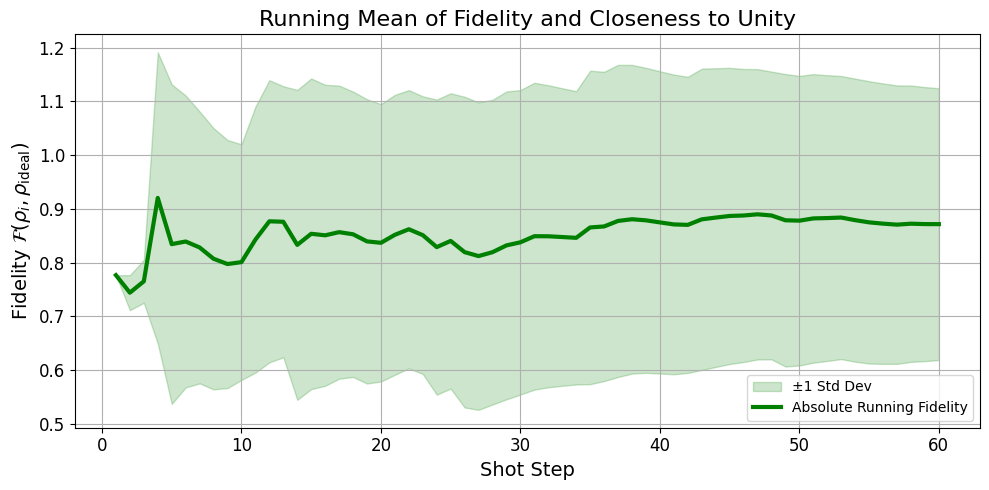

In [24]:
def plot_fidelity_metrics(fidelity_vals, p, max_steps=None):
    """
    Plot the running mean of fidelity values and their absolute closeness to 1.

    Parameters:
    - fidelity_vals: list of fidelity values (each ∈ [0, 1])
    - max_steps: optional int, number of steps to include (default = all)
    """
    if max_steps is not None:
        fidelity_vals = fidelity_vals[:max_steps]

    # Compute running mean and std
    running_mean = []
    running_std = []

    for i in range(1, len(fidelity_vals) + 1):
        current = fidelity_vals[:i]
        running_mean.append(np.mean(current))
        running_std.append(np.std(current))

    running_mean = np.array(running_mean)
    running_std = np.array(running_std)
    steps = np.arange(1, len(fidelity_vals) + 1)

    # Closeness to fidelity 1
    closeness_to_one = 1 - np.abs(1 - running_mean)
    

    # --- Plot ---
    plt.figure(figsize=(10, 5))

    # Running mean line
    #plt.plot(steps, running_mean, label='Running Mean Fidelity', color='green', linewidth=3)

    # Std deviation band
    plt.fill_between(steps,
                     closeness_to_one - running_std,
                     closeness_to_one + running_std,
                     color='green',
                     alpha=0.2,
                     label='±1 Std Dev')

    # Closeness curve
    plt.plot(steps, closeness_to_one, label='Absolute Running Fidelity', color='green', linewidth=3)

    # Labels and formatting
    plt.xlabel('Shot Step', fontsize=14)
    plt.ylabel(r'Fidelity $\mathcal{F}(\rho_i, \rho_{\mathrm{ideal}})$', fontsize=14)
    plt.title(r'Running Mean of Fidelity and Closeness to Unity', fontsize=16)
    plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_fidelity_metrics(fidelity_vals, p_sim, max_steps=shots)
plot_fidelity_metrics(fidelity_vals, p_sim, max_steps=200)
plot_fidelity_metrics(fidelity_vals, p_sim, max_steps=60)




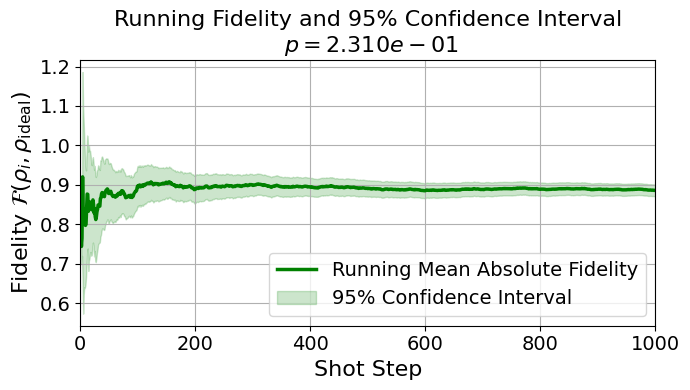

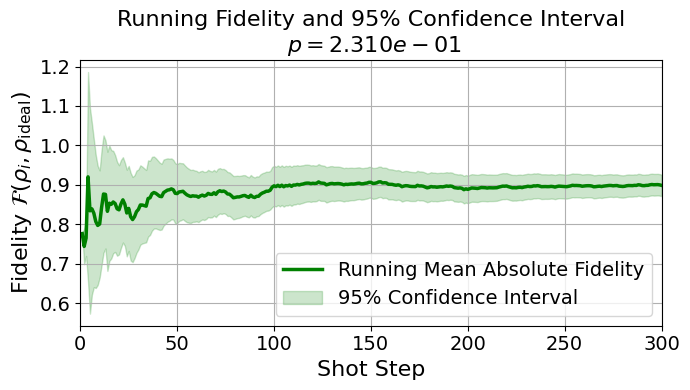

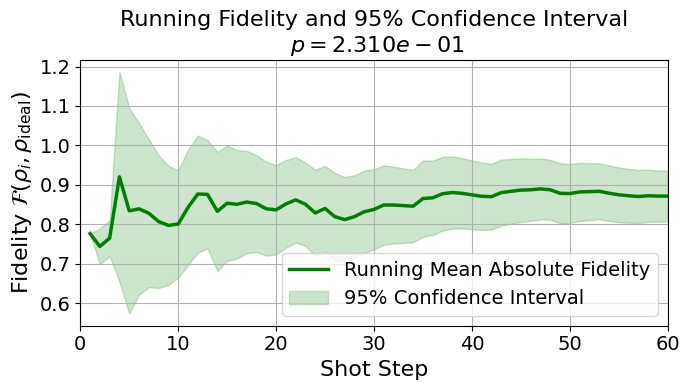

In [25]:

def plot_fidelity_metrics_with_ci(fidelity_vals, p, max_steps=None, confidence=0.95):
    """
    Plot the running mean of fidelity values with a confidence interval band and closeness to unity.

    Parameters:
    - fidelity_vals: list of fidelity values (each ∈ [0, 1])
    - max_steps: optional int, number of steps to include (default = all)
    - confidence: confidence level for the CI (default = 0.95)
    """
    fidelity_vals = np.array(fidelity_vals)
    
    if max_steps is not None:
        fidelity_vals = fidelity_vals[:max_steps]

    steps = np.arange(1, len(fidelity_vals) + 1)
    running_mean = np.cumsum(fidelity_vals) / steps
    
    # Closeness to fidelity 1
    closeness_to_one = 1 - np.abs(1 - running_mean)

    # Compute standard error and confidence interval
    std_vals = np.array([np.std(fidelity_vals[:i]) for i in steps])
    stderr_vals = std_vals / np.sqrt(steps)
    z = 1.96  # for 95% confidence
    ci_upper = running_mean + z * stderr_vals
    ci_lower = running_mean - z * stderr_vals

    # --- Plot ---
    plt.figure(figsize=(7, 4))

    # Running mean
    plt.plot(steps, closeness_to_one, label='Running Mean Absolute Fidelity', color='green', linewidth=2.5)

    # Confidence interval band
    plt.fill_between(steps,
                     ci_lower,
                     ci_upper,
                     color='green',
                     alpha=0.2,
                     label='95% Confidence Interval')


    # Formatting
    plt.xlabel('Shot Step', fontsize=16)
    plt.ylabel(r'Fidelity $\mathcal{F}(\rho_i, \rho_{\mathrm{ideal}})$', fontsize=16)
    plt.title(r'Running Fidelity and 95% Confidence Interval'+ 
        f'\n $p = {p:.3e}$', fontsize=16)
    plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0), fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0, max_steps)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_fidelity_metrics_with_ci(fidelity_vals, p_sim, max_steps=shots)
plot_fidelity_metrics_with_ci(fidelity_vals, p_sim, max_steps=300)
plot_fidelity_metrics_with_ci(fidelity_vals, p_sim, max_steps=60)


Plot changes in Fidelity with worse noise
- call many shots with each p
- call many shots with each t

In [26]:

def run_parameter_sweep_with_closeness(param_name, param_range, shots, psi0_flat, p, T1, T2, tg, simulate_func, ideal_state, additional_noise = False):
    """
    Run a sweep over a specified noise parameter for a 4-qubit noisy surface code simulation,
    returning trace closeness to unity instead of raw trace norm.

    Parameters:
    - param_name: str, one of 'p', 'T1', 'T2', or 'tg'
    - param_range: iterable of values to sweep over for the parameter
    - shots: int, number of shots per parameter setting
    - psi0_flat: initial state
    - p, T1, T2, tg: default values for noise parameters
    - simulate_func: function handle to the simulation function
    - ideal_state: Qobj, ideal pure state for fidelity comparisons

    Returns:
    - results_dict: dictionary {param_val: [psi_outcomes]}
    - closeness_dict: dictionary {param_val: [1 - abs(1 - trace norm)]}
    - fidelity_dict: dictionary {param_val: [fidelity values]}
    - avg_closeness: dictionary {param_val: mean closeness}
    - avg_fidelities: dictionary {param_val: mean fidelity}
    """
    results_dict = {}
    closeness_dict = {}
    fidelity_dict = {}
    fidelity_close_dict = {}
    avg_closeness = {}
    avg_fidelities = {}
    avg_fidelities_close = {}

    for val in param_range:
        kwargs = {'p': p, 'T1': T1, 'T2': T2, 'tg': tg}
        kwargs[param_name] = val

        counts, psi_outcomes = simulate_func(psi0_flat, **kwargs, shots=shots, additional_noise=additional_noise)
        results_dict[val] = psi_outcomes

        trace_vals = [psi.norm()**2 for psi in psi_outcomes]
        closeness_vals = [1 - abs(1 - tr) for tr in trace_vals]
        
        fidelity_vals = [fidelity(psi, ideal_state) for psi in psi_outcomes]
        fid_close_val = [1 - np.abs(1 - fid) for fid in fidelity_vals]
        

        closeness_dict[val] = closeness_vals
        fidelity_dict[val] = fidelity_vals
        fidelity_close_dict[val] = fid_close_val
        avg_closeness[val] = np.mean(closeness_vals)
        avg_fidelities[val] = np.mean(fidelity_vals)
        avg_fidelities_close[val] = np.mean(fid_close_val)
        
    return results_dict, closeness_dict, fidelity_dict, avg_closeness, avg_fidelities, fidelity_close_dict, avg_fidelities_close


In [27]:
# Assume default p, T1, T2, tg are already defined
p_vals = np.logspace(-1, 6, num=20) * p  # 0.1p to 10000p, log scale

results, closeness_dict, fidelity_dict, avg_closeness, avg_fidelities, fidelity_close_dict, avg_fidelities_close = run_parameter_sweep_with_closeness(
    param_name='p',
    param_range=p_vals,
    shots=100,
    psi0_flat=psi0_flat,
    p=p, T1=T1, T2=T2, tg=tg,
    simulate_func=simulate_noisy_4_qubit_surface,
    ideal_state=ideal_state
)

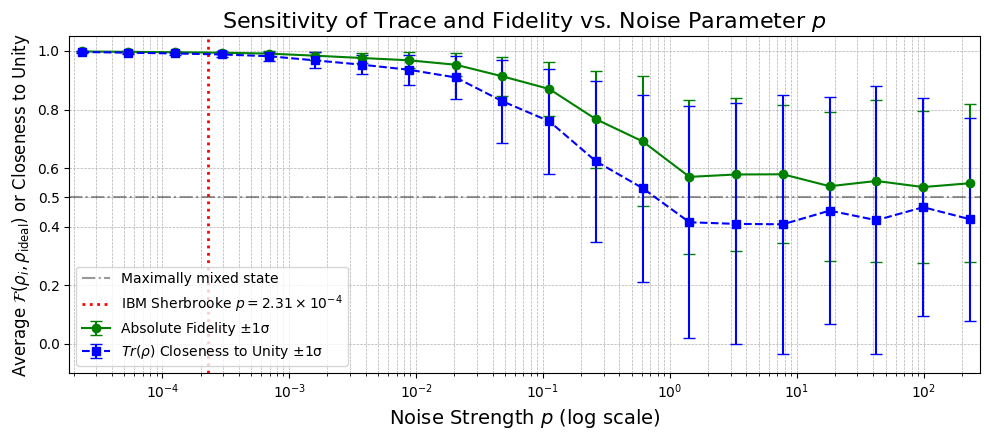

In [28]:


# Extract means and standard deviations
x_vals = p_vals
y_trace = [avg_closeness[pval] for pval in x_vals]
y_fid = [avg_fidelities[pval] for pval in x_vals]
y_fid_close = [avg_fidelities_close[pval] for pval in x_vals]
err_trace = [np.std(closeness_dict[pval]) for pval in x_vals]
err_fid = [np.std(fidelity_dict[pval]) for pval in x_vals]
err_close_fid = [np.std(fidelity_close_dict[pval]) for pval in x_vals]

# Plot
plt.figure(figsize=(10, 4.5))
plt.axhline(
    y=0.5,
    color='black',
    linestyle='-.',
    alpha=0.4,  # adjust for transparency
    label='Maximally mixed state'
)

# Plot fidelity with error bars
#plt.errorbar(x_vals, y_fid, yerr=err_fid, fmt='o-', label='Average Fidelity ±1σ', color='green', capsize=4)
plt.errorbar(x_vals, y_fid_close, yerr=err_close_fid, fmt='o-', label='Absolute Fidelity ±1σ', color='green', capsize=4)

# Plot trace closeness with error bars
plt.errorbar(x_vals, y_trace, yerr=err_trace, fmt='s--', label=r'${Tr(\rho)}$ Closeness to Unity ±1σ', color='blue', capsize=4)

exponent = int(np.floor(np.log10(p)))
mantissa = p / (10**exponent)

plt.axvline(
    p,
    color='red',
    linestyle=':',
    linewidth=2,
    label=fr'IBM Sherbrooke $p = {mantissa:.2f} \times 10^{{{exponent}}}$'
)
# Logarithmic x-axis
plt.xscale('log')

# Labels and formatting
plt.xlabel(r'Noise Strength $p$ (log scale)', fontsize=14)
plt.ylabel(r'Average $\mathcal{F}(\rho_i, \rho_{\mathrm{ideal}})$ or Closeness to Unity', fontsize=12)
plt.title(r'Sensitivity of Trace and Fidelity vs. Noise Parameter $p$', fontsize=16)
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
# Add y=0.5 tick
y_ticks = plt.yticks()[0]
if 0.5 not in y_ticks:
    y_ticks = np.append(y_ticks, 0.5)
plt.yticks(sorted(y_ticks))
plt.ylim(-0.1,1.05)
plt.xlim(x_vals[0]-x_vals[0]*0.2, x_vals[-1]+x_vals[-1]*0.2)
plt.tight_layout()
plt.show()

In [29]:
# Assume default p, T1, T2, tg are already defined
tg_vals = np.logspace(-1, 3.3, num=20) * tg  # 0.1p to 10000tg, log scale

results, closeness_dict, fidelity_dict, avg_closeness, avg_fidelities, fidelity_close_dict, avg_fidelities_close = run_parameter_sweep_with_closeness(
    param_name='tg',
    param_range=tg_vals,
    shots=100,
    psi0_flat=psi0_flat,
    p=p, T1=T1, T2=T2, tg=tg,
    simulate_func=simulate_noisy_4_qubit_surface,
    ideal_state=ideal_state,
    additional_noise=True
)

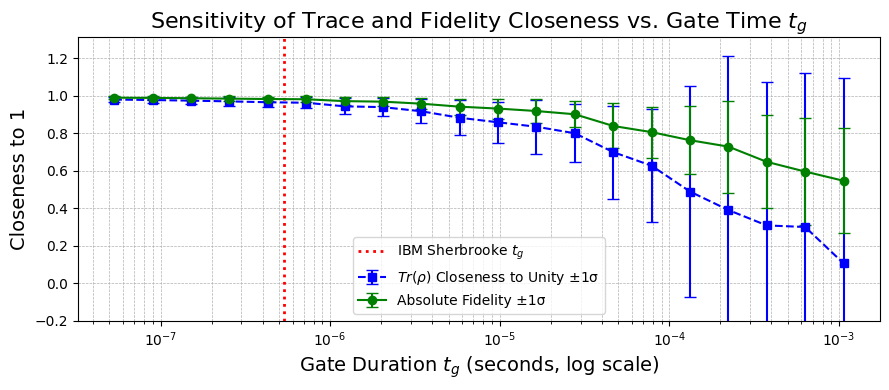

In [30]:
# Extract means
x_vals = tg_vals
y_trace = [avg_closeness[val] for val in x_vals]
y_fid_close = [avg_fidelities_close[val] for val in x_vals]
err_trace = [np.std(closeness_dict[val]) for val in x_vals]
err_close_fid = [np.std(fidelity_close_dict[val]) for val in x_vals]

# Plot
plt.figure(figsize=(9, 4))

# Plot with error bars
plt.errorbar(x_vals, y_trace, yerr=err_trace, fmt='s--', label=r'${Tr(\rho)}$ Closeness to Unity ±1σ', color='blue', capsize=4)
plt.errorbar(x_vals, y_fid_close, yerr=err_close_fid, fmt='o-', label='Absolute Fidelity ±1σ', color='green', capsize=4)


# Reference line for IBM Sherbrooke tg
plt.axvline(tg, color='red', linestyle=':', linewidth=2, label=r'IBM Sherbrooke $t_g$')

# Log x-axis
plt.xscale('log')

# Labels and formatting
plt.xlabel(r'Gate Duration $t_g$ (seconds, log scale)', fontsize=14)
plt.ylabel(r'Closeness to 1', fontsize=14)
plt.title(r'Sensitivity of Trace and Fidelity Closeness vs. Gate Time $t_g$', fontsize=16)
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.ylim(-0.2)
plt.show()


Computing Hellinger Distance

$$ \mathcal{H}(\rho, \sigma) = \dfrac{1}{\sqrt{2}} \sqrt{\sum_{k=1}^N ( \sqrt{\rho_{kk}} - \sqrt{\sigma_{kk}} )^2}$$

In [31]:

def hellinger_distance_diag(rho, sigma):
    """
    Compute the classical Hellinger distance between the diagonals of two density matrices.
    
    Parameters:
    - rho: Qobj, quantum state (pure or mixed)
    - sigma: Qobj, quantum state (pure or mixed)
    
    Returns:
    - Classical Hellinger distance between the diagonals (float)
    """
    # Ensure density matrices
    rho_diag = np.real(rho.diag())
    sigma_diag = np.real(sigma.diag())
    
    # Normalize just in case
    rho_diag /= np.sum(rho_diag)
    sigma_diag /= np.sum(sigma_diag)
    
    # Classical Hellinger distance formula
    diff = np.sqrt(rho_diag) - np.sqrt(sigma_diag)
    H = (1 / np.sqrt(2)) * np.linalg.norm(diff)
    return H


In [32]:


def run_hellinger_sweep(param_name, param_range, shots, psi0_flat, p, T1, T2, tg, simulate_func, ideal_state, additional_noise=False):
    """
    Run a sweep over a noise parameter and compute the Hellinger distance (diagonal only)
    between the simulated output state and the ideal state for each shot.
    """

    hellinger_dict = {}
    avg_hellinger = {}

    for val in param_range:
        kwargs = {'p': p, 'T1': T1, 'T2': T2, 'tg': tg}
        kwargs[param_name] = val

        counts, psi_outcomes = simulate_func(psi0_flat, **kwargs, shots=shots, additional_noise=additional_noise)

        hellinger_vals = [hellinger_distance_diag(ket2dm(psi), ket2dm(ideal_state)) for psi in psi_outcomes]
        hellinger_dict[val] = hellinger_vals
        avg_hellinger[val] = np.mean(hellinger_vals)

    return hellinger_dict, avg_hellinger


In [33]:
# Assume default p, T1, T2, tg are already defined
tg_vals = np.logspace(-2, 3.3, num=20) * tg  # 0.1p to 10000tg, log scale

hellinger_dict, avg_hellinger = run_hellinger_sweep(
    param_name='tg',
    param_range=tg_vals,
    shots=10,
    psi0_flat=psi0_flat,
    p=p, T1=T1, T2=T2, tg=tg,
    simulate_func=simulate_noisy_4_qubit_surface,
    ideal_state=ideal_state,
    additional_noise=True
)



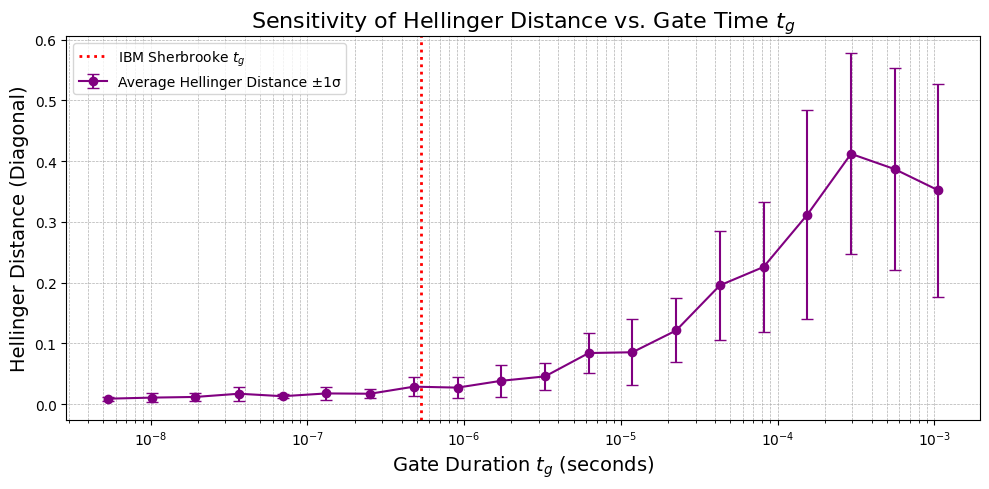

In [34]:
# Extract data
x_vals = tg_vals
y_vals = [avg_hellinger[val] for val in x_vals]
y_errs = [np.std(hellinger_dict[val]) for val in x_vals]

# Plot
plt.figure(figsize=(10, 5))

plt.errorbar(x_vals, y_vals, yerr=y_errs, fmt='o-', color='purple', capsize=4, label='Average Hellinger Distance ±1σ')

# Reference line for IBM Sherbrooke tg
plt.axvline(tg, color='red', linestyle=':', linewidth=2, label=r'IBM Sherbrooke $t_g$')
plt.xscale('log')
plt.xlabel(r'Gate Duration $t_g$ (seconds)', fontsize=14)
plt.ylabel(r'Hellinger Distance (Diagonal)', fontsize=14)
plt.title(r'Sensitivity of Hellinger Distance vs. Gate Time $t_g$', fontsize=16)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()